<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Income_fluctuation_problem_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64, jitclass, prange
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain

In [3]:
ifp_data=[('R', float64),
     ('beta', float64),
     ('gamma', float64),
     ('P', float64[:,:]),
     ('y', float64[:]),
     ('asset_grids', float64[:])
    ]

@jitclass(ifp_data)
class IFPModel:
  def __init__(self, r=0.01,
            beta=0.96,
            gamma=1.5,
            P=((0.6, 0.4),
             (0.05, 0.95)),
            y=(0.0, 2.0),
            grid_min=0,
            grid_max=16,
            grid_size=50):
    
    self.R, self.beta, self.gamma = 1+r, beta, gamma
    self.asset_grids = np.linspace(grid_min, grid_max, grid_size)
    self.P = np.array(P)
    self.y = np.array(y)
    assert self.R * self.beta < 1, "Stability condition violated."

  def u(self, c):
    gamma = self.gamma
    return np.log(c) if gamma == 1 else c**(1-gamma)/(1-gamma) 
  
  def u_prime(self, c):
    gamma = self.gamma
    return 1/c if gamma==1 else c**(-gamma) 
  
  def u_prime_inverse(self, u):
    gamma = self.gamma
    return 1/u if gamma==1 else u**(-1/gamma)

@njit
def euer_diff(c, a, z, sigma, ifp):
  u_prime, beta, R, a_grids, y, P = ifp.u_prime, ifp.beta, ifp.R, ifp.asset_grids, ifp.y, ifp.P

  def fun_sigma(A, Z):
    return interp(a_grids, sigma[:,Z], A)

  expected = 0
  for i in range(len(P)):
    expected += u_prime(fun_sigma(R*(a-c)+y[i], i)) * P[z, i]
  diff = u_prime(c) - max(beta*R*expected, u_prime(a))
  return diff

@njit
def compute_root(a, z, sigma, ifp):
  root = brentq(euer_diff, 1e-10, a-1e-10, args=(a, z, sigma, ifp))[0]
  return root

@njit
def K(sigma, ifp):
  a_grids, P = ifp.asset_grids, ifp.P
  Ksigma = np.empty_like(sigma)
  for z in range(len(P)):
    for i in range(len(a_grids)):
      a = a_grids[i]
      if a < 1e-12:
        Ksigma[i, z] = 0
      else:
        Ksigma[i, z] = compute_root(a, z, sigma, ifp)
  return Ksigma


def compute_policy_function(ifp, max_iter=1000, tol=1e-4, verbose=True):
  sigma = np.column_stack((ifp.asset_grids, ifp.asset_grids))

  i = 0
  err = 1 + tol
  while i < max_iter and err > tol:
    Ksigma = K(sigma, ifp)
    i += 1
    err = np.max(np.abs(Ksigma - sigma))
    sigma = Ksigma
    if verbose and i%25==0:
      print(f'Error is {err} at interation {i}.')
    
  if i == max_iter:
    raise RuntimeError('Iteration failed.')
  
  if verbose:
    print(f'\nConverged on interation {i}!')

  return sigma

In [4]:
%%time

ifp = IFPModel(gamma=1.5, grid_min=0)
sigma = compute_policy_function(ifp)

Error is 0.011629589188415057 at interation 25.
Error is 0.0003857183099671424 at interation 50.

Converged on interation 60!
CPU times: user 2.54 s, sys: 15.3 ms, total: 2.56 s
Wall time: 2.56 s


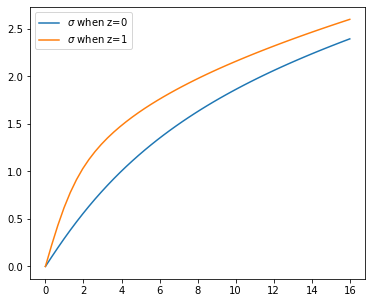

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i in range(len(ifp.P)):
  ax.plot(ifp.asset_grids, sigma[:, i], label=fr'$\sigma$ when z={i}')
ax.legend();

In [6]:
def c_star(x, ifp):
  beta, gamma = ifp.beta, ifp.gamma
  return (1 - beta ** (1/gamma)) * x


def v_star(x, ifp):
  beta, gamma = ifp.beta, ifp.gamma
  return (1 - beta**(1 / gamma))**(-gamma) * (x**(1-gamma) / (1-gamma))

In [7]:
%%time

ifp_cake_eating = IFPModel(r=0, y=(0.0, 0.0))
sigma_ce = compute_policy_function(ifp_cake_eating)

Error is 0.023332272630518403 at interation 25.
Error is 0.005301238424149757 at interation 50.
Error is 0.00197063246255591 at interation 75.
Error is 0.0008675521338489811 at interation 100.
Error is 0.0004107354220824755 at interation 125.
Error is 0.00020120334007689422 at interation 150.
Error is 0.00010021430783813123 at interation 175.

Converged on interation 176!
CPU times: user 455 ms, sys: 4.8 ms, total: 460 ms
Wall time: 458 ms


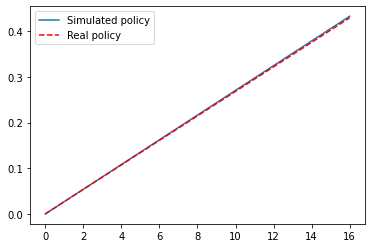

In [8]:
grids = ifp_cake_eating.asset_grids
plt.plot(grids, sigma_ce[:,0], label='Simulated policy')
plt.plot(grids, c_star(grids, ifp_cake_eating), 'r--', label='Real policy')
plt.legend();

## Exercise 1

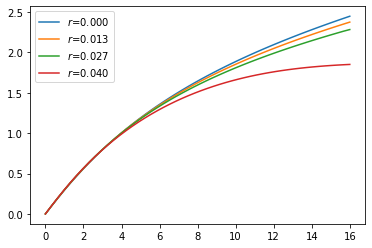

In [9]:
rs = np.linspace(0, 0.04, 4)
for r in rs:
  ifp_ = IFPModel(r = r)
  sigma_ = compute_policy_function(ifp_, verbose=False)
  plt.plot(ifp_.asset_grids, sigma_[:, 0], label=fr'$r$={r:.3f}')
plt.legend();

## Exercise 2

In [10]:
mc = MarkovChain(ifp.P)
z_draws = mc.simulate(ts_length=500_000)

@njit
def Simulations(ifp, sigma, z_draws, a=4, T=500_000):
  asset_grids, P, R, Y = ifp.asset_grids, ifp.P, ifp.R, ifp.y
  asset = np.zeros(T+1)
  asset[0] = a
  
  def Sigma(a, z):
    return interp(asset_grids, sigma[:, z], a)

  for i in range(T):
    c = Sigma(asset[i], z_draws[i])
    asset[i+1] = R*(asset[i] - c) + Y[z_draws[i]]
  
  return asset

In [11]:
%%time

asset = Simulations(ifp, sigma, z_draws)

CPU times: user 285 ms, sys: 5.01 ms, total: 290 ms
Wall time: 290 ms


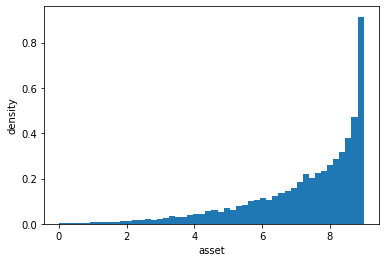

In [12]:
plt.hist(asset, bins=50, density=True)
plt.xlabel('asset')
plt.ylabel('density');

## Exercise 3

In [13]:
%%time
interest_rates = np.linspace(0, 0.03, 20)
aggregate_capital = np.empty_like(interest_rates)
for i, r_val in enumerate(interest_rates):
  ifp_ = IFPModel(r=r_val)
  sigma_ = compute_policy_function(ifp_, verbose=False)
  aggregate_capital[i] = Simulations(ifp_, sigma_, z_draws).mean()

CPU times: user 2.37 s, sys: 9.79 ms, total: 2.38 s
Wall time: 2.38 s


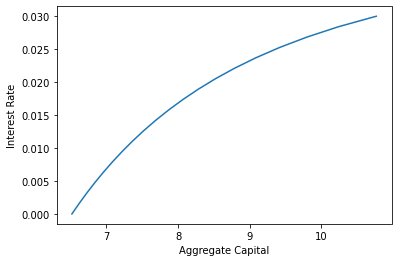

In [14]:
plt.plot(aggregate_capital, interest_rates, label='Agg capital as a function of r')
plt.xlabel('Aggregate Capital')
plt.ylabel('Interest Rate');